# Handwritten Digit Classfication using Lenet

In [1]:
%pylab inline

import pandas
import datetime as dt

from nn.layer import *
from nn.criterion import *
from optim.optimizer import *
from util.common import *
from dataset.transformer import *
from dataset import mnist

init_engine()

Populating the interactive namespace from numpy and matplotlib


## 1. Train the network

* prepare train and validation samples

In [6]:
# Get and store MNIST into RDD of Sample
mnist_path = "/home/yang/sources/datasets/mnist"
def get_minst(data_type="train"):
    # target is start from 0,
    (images, labels) = mnist.read_data_sets(mnist_path, data_type)
    mean = np.mean(images)
    std = np.std(images)
    images = sc.parallelize(images)
    labels = sc.parallelize(labels)
    record = images.zip(labels).map(lambda (features, label):
        Sample.from_ndarray((features - mean)/std, label + 1)) # Both features and labels are ndarray, and BigDL target starts from 1
    return record

train_data = get_minst("train")
test_data = get_minst("test")
print train_data.count()
print test_data.count()

('Extracting', '/home/yang/sources/datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', '/home/yang/sources/datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


* create the lenet-5 model

In [7]:
# Create a LeNet model
def build_model(class_num):
    model = Sequential()
    model.add(Reshape([1, 28, 28]))
    model.add(SpatialConvolution(1, 6, 5, 5).set_name('conv1'))
    model.add(Tanh())
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool1'))
    model.add(Tanh())
    model.add(SpatialConvolution(6, 12, 5, 5).set_name('conv2'))
    model.add(SpatialMaxPooling(2, 2, 2, 2).set_name('pool2'))
    model.add(Reshape([12 * 4 * 4]))
    model.add(Linear(12 * 4 * 4, 100).set_name('fc1'))
    model.add(Tanh())
    model.add(Linear(100, class_num).set_name('score'))
    model.add(LogSoftMax())
    return model
lenet_model = build_model(10)
lenet_model

creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createTanh
creating: createSpatialMaxPooling
creating: createTanh
creating: createSpatialConvolution
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createTanh
creating: createLinear
creating: createLogSoftMax


* configure optimizer

In [8]:

# Create an Optimizer
state = {"learningRate": 0.4,
         "learningRateDecay": 0.0002}
optimizer = Optimizer(
    model=lenet_model,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(),
    optim_method="SGD",
    state=state,
    end_trigger=MaxEpoch(20),
    batch_size=2048)

# Set the validation logic
optimizer.setvalidation(
    batch_size=2048,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=["Top1Accuracy"]
)

app_name='lenet-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to ",app_name
# Set the model checkpoint logic
#optimizer.setcheckpoint(EveryEpoch(), "/tmp/lenet5/")

#You would see the model snapshot at dir:/tmp/lenet5/ for every epoch

creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  lenet-20170420-095456


* Train the network. Wait some time till it finished.. Voila! You've got a trained model

In [9]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 5min 1s


## 2 Inspect the prediction results

In [10]:
def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

* Let's first take a few training samples and check the labels

Ground Truth labels:
5.0, 0.0, 4.0, 1.0, 9.0, 2.0, 1.0, 3.0


(-0.5, 223.5, 27.5, -0.5)

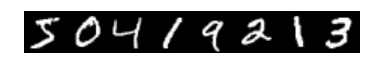

In [11]:
# label-1 to restore the original label.
print "Ground Truth labels:" 
print ', '.join([str(map_groundtruth_label(s.label)) for s in train_data.take(8)])
imshow(np.column_stack([np.array(s.features).reshape(28,28) for s in train_data.take(8)]),cmap='gray'); axis('off')

* Make predictions, take a few test samples, check the predicted labels and ground truth labels

Ground Truth labels:
7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0
Predicted labels:
7, 2, 1, 0, 4, 1, 4, 9
CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 774 ms


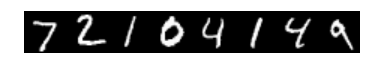

In [12]:
%%time
predictions = trained_model.predict(test_data)
imshow(np.column_stack([np.array(s.features).reshape(28,28) for s in test_data.take(8)]),cmap='gray'); axis('off')
print 'Ground Truth labels:'
print ', '.join(str(map_groundtruth_label(s.label)) for s in test_data.take(8))
#print 'Ground Truth:'
#print '\t'.join([str(s.label) for s in ground_truth])
print 'Predicted labels:'
print ', '.join(str(map_predict_label(s)) for s in predictions.take(8))

## 3 Inspect the model

Now look at the parameter shapes. The parameters are exposed as a dict, and can be retrieved using model.parameters().

The param shapes typically have the form (batch_number?, output_channels, input_channels, filter_height, filter_width) (for the weights) and the 1-dimensional shape (output_channels,) (for the biases).

In [13]:
params = trained_model.parameters()

#batch num, output_dim, input_dim, spacial_dim
for layer_name, param in params.iteritems():
    print layer_name,param['weight'].shape,param['bias'].shape

conv2 (1, 12, 6, 5, 5) (12,)
conv1 (1, 6, 1, 5, 5) (6,)
score (10, 100) (10,)
fc1 (100, 192) (100,)


* visualize the weights

In [14]:
#vis_square is borrowed from caffe example
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
  
    plt.imshow(data,cmap='gray'); plt.axis('off')

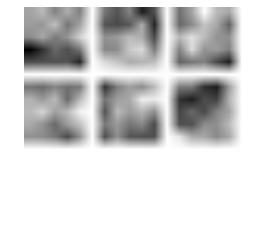

In [15]:
filters_conv1 = params['conv1']['weight']

filters_conv1[0,0,0]

vis_square(np.squeeze(filters_conv1, axis=(0,)).reshape(1*6,5,5))

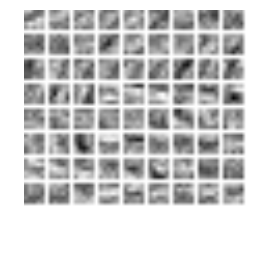

In [16]:
# the parameters are a list of [weights, biases]
filters_conv2 = params['conv2']['weight']

vis_square(np.squeeze(filters_conv2, axis=(0,)).reshape(12*6,5,5))

## 4 Draw the learning curves

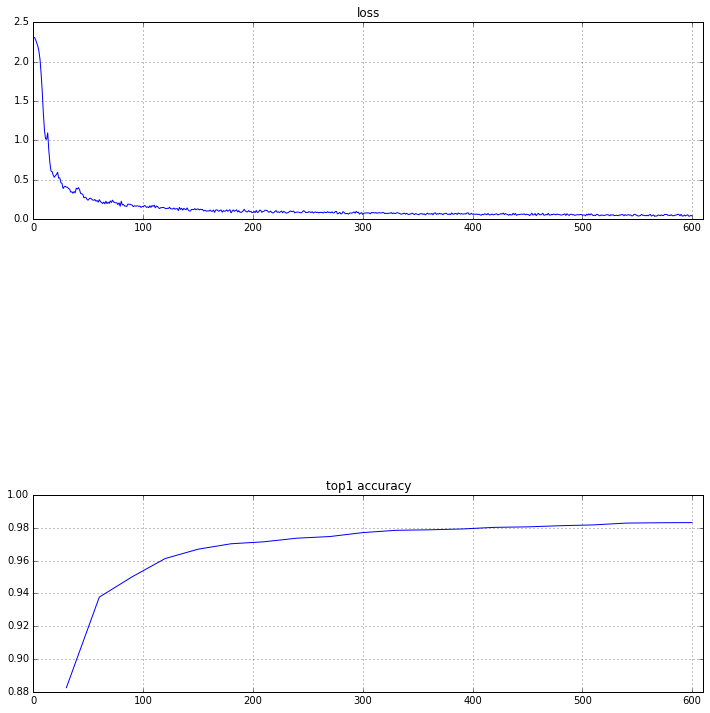

In [17]:
loss = np.array(train_summary.read_scalar("Loss"))
lr = np.array(train_summary.read_scalar("LearningRate"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(3,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(3,1,3)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)